In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import pandas as pd
import matplotlib.gridspec as gridspec 
import pickle
import nibabel as nib
from tvb.simulator.lab import *
import bct as bct
import os
import pickle

# write python dict to a file
output = open('/home/etienne/notebooks/ID_A148_to_Grandj_reduced.pkl', 'rb')
ID_A148_to_Grandj_reduced=pickle.load(output)
output.close()

path ='/home/etienne/data/Grandjean_mouse_fMRI/'
micetable=pd.read_csv(path+'participants.tsv',sep='\s+')

remove_roi=[55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
            129, 130,  131,  132,  133,  134,  135,  136,  137,  138,  139,  140, 141, 142, 143,144,145,146,147, 27, 101]


sys.path.insert(0, '/home/etienne')
from src import analysis, simulation  # Import analysis for fcd and clustering
regions=pd.read_csv('modules.csv')
regions["remove_ROI"]=np.isin(regions.index.tolist(),remove_roi)

regions108=regions[regions.remove_ROI==False]
regions108.index=np.arange(108)

/home/etienne/env/src/tvb-library/scientific_library/tvb/datatypes/surfaces.py:61: UserWarning: Geodesic distance module is unavailable; some functionality for surfaces will be unavailable.
  warnings.warn(msg)


In [2]:
# Import the anatomical structural connectivity.
path='/home/etienne/data/connectivity/'
A148_con = connectivity.Connectivity.from_file(path+'Allen_148.zip')
nregions = len(A148_con.weights)     #number of regions
A148_con.speed = np.asarray(np.inf)  #set the conduction speed
np.fill_diagonal(A148_con.weights, 0.)
A148_con.weights = A148_con.weights/np.max(A148_con.weights) #normalization
A148_con.configure()
A148_SC = A148_con.weights

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


In [3]:
def edges_str(Bold):
    return(np.sqrt(np.sum(analysis.go_edge(Bold)**2,axis=1)))

def functional_hub(Bold,nregions=5):
    #Return the nregions regions having the biggest participation in the 3 biggest eigenvectors (moduled by the eigenvalues)
    #The regions are sorted in a decreasing importance 
    
    FC=np.corrcoef(Bold.T)
    if np.isnan(FC).any():
        M=np.zeros(nregions)
        M[:]=np.nan
        return(M)
    D,E=np.linalg.eig(FC)
    order=np.argsort(np.sum(np.abs(E[:,:3])*D[:3],axis=1))
    return(np.flip(order[-nregions:]))

def edge_to_FC(edge,n=108):
    
    #Make the Functional Connectivity matrix from an edge
    
    A=np.zeros((n,n))
    triu=np.triu_indices(n, 1)
    A[triu]=edge
    tril=(triu[1],triu[0])
    A[tril]=edge
    A[np.arange(n),np.arange(n)]=[1]*n
    return(A)


def CAP(B1,thresh=95):
    #Return the co-activation patterns (edges) of strongest RSS of the Bold signal
    #If there are consecutives CAP of high RSS they are averaged 
    
    volume=B1.shape[0]
    constant_reg=np.arange(108)[np.isnan(stats.zscore(B1))[0,:]]
    
    B1[:,constant_reg.tolist()]=np.random.normal(size=volume*constant_reg.shape[0]).reshape((volume,constant_reg.shape[0]))
    Edges=analysis.go_edge(B1)
    
    RSS=edges_str(B1)
    p=np.percentile(RSS,thresh)
    edgec=np.arange(volume)[RSS>p]
    keep=[True]*edgec.shape[0]
    CAP=[]
    j=0
    for k in edgec:
        cap=Edges[k,:]
        i=1
        while np.isin(edgec,k+i).any():
            cap+=Edges[k+i,:]
            edgec=np.delete(edgec,np.where(edgec==k+i))
            keep[j+i]=False
            i+=1
        j+=1
        cap=cap/i
        CAP.append(cap)
    CAP=np.array(CAP)
    return(CAP[keep])

In [4]:
path='/home/etienne/data/Grandjean_mouse_fMRI/timeseries/'

bold={}
i=0
for filename in os.listdir(path):
    with open(os.path.join(path, filename), 'r') as f: # open in readonly mode
        bold['%d'%(i+1)]=np.loadtxt(path+filename)
    i+=1

In [5]:
indexwt=micetable[(micetable.genotype=='wild-type')&(micetable.volume==500)].index.tolist()
boldwt={}
for k in indexwt:
    boldwt[str(k)]=bold[str(k)]

In [6]:
Boldwt={}
nregions=148
regcorr=np.arange(nregions)[np.isin(np.arange(nregions),remove_roi)==False]

for j in indexwt:
    volume=bold[str(j)].shape[0]
    bd=np.zeros((volume,nregions))
    for i in range(nregions):
        bd[:,i]=boldwt['%d'%j][:,ID_A148_to_Grandj_reduced['%d'%i]]
    Boldwt['%d'%j]=bd[:,regcorr]

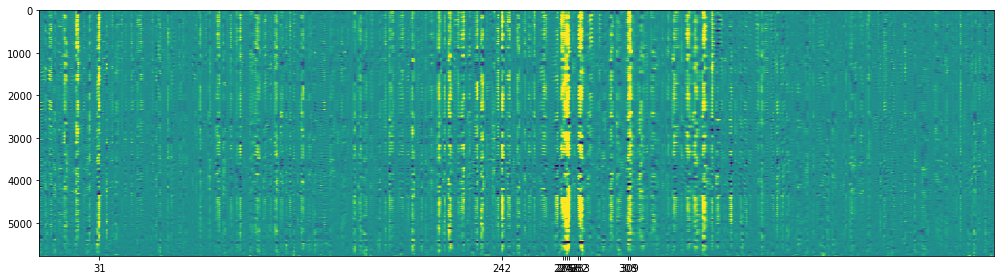

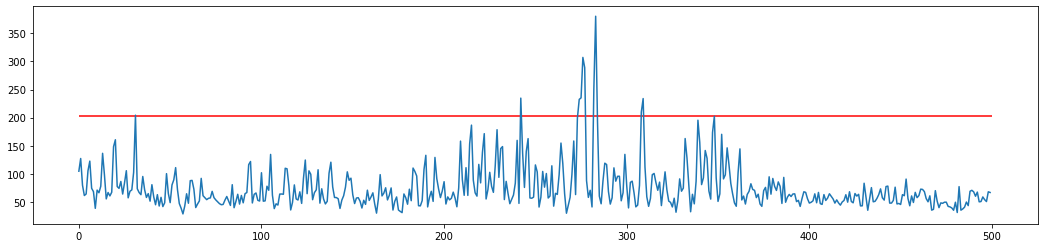

In [7]:
subject=42
B1=Boldwt[str(subject)]
volume=B1.shape[0]
constant_reg=np.arange(108)[np.isnan(stats.zscore(B1))[0,:]]

B1[:,constant_reg.tolist()]=np.random.normal(size=volume*constant_reg.shape[0]).reshape((volume,constant_reg.shape[0]))
Edges=analysis.go_edge(B1)
eFCD=np.corrcoef(Edges)

p=np.percentile(edges_str(B1),98)
edgec=np.arange(500)[edges_str(B1)>p]

plt.figure(figsize=(14,4))
plt.imshow(Edges[:,:].T,aspect='auto', cmap='viridis',vmin=-2.5,vmax=2.5)
plt.xticks(edgec)
#plt.colorbar()

plt.tight_layout()

plt.show()
plt.figure(figsize=(18,4))
plt.plot(edges_str(B1))
plt.hlines(p,xmin=0,xmax=500,colors='r')

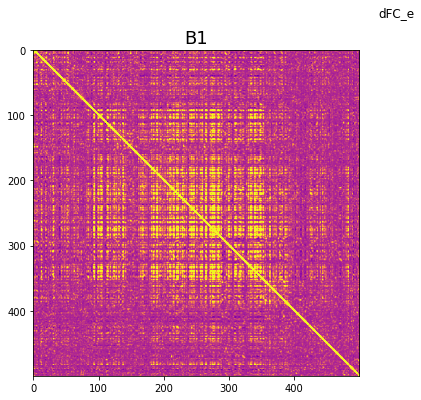

In [8]:
plt.figure(figsize=(14,6))
plt.suptitle('dFC_e')
plt.subplot(121)
plt.title('B1',fontsize=18)
plt.imshow(np.corrcoef(analysis.go_edge(B1)),cmap='plasma',vmax=0.2)

In [9]:
select=np.isin(np.arange(148),remove_roi)==False
A108_SC=A148_SC[:,select][select,:]
A108_SCS=(A108_SC+A108_SC.T)/2

In [39]:
corr1=[]
for subject in Boldwt.keys():
    B1=Boldwt[subject]
    ca=(CAP(B1,thresh=98))
    M=np.zeros((ca.shape[0],108))
    
    for k in range(ca.shape[0]):
        var=ca[k,:]
        fc=edge_to_FC(var)
        w,v=np.linalg.eig(fc)
        for p in range(108):
            M[k,p]=stats.pearsonr((v[:,0]),A108_SC[p,:])[0]
    corr1.append(M)

/home/etienne/env/lib/python3.8/site-packages/scipy/stats/stats.py:3960: ComplexWarning: Casting complex values to real discards the imaginary part
  prob = 2*special.btdtr(ab, ab, 0.5*(1 - abs(np.float64(r))))
<ipython-input-39-301bbbb0da6c>:12: ComplexWarning: Casting complex values to real discards the imaginary part
  M[k,p]=stats.pearsonr((v[:,0]),A108_SC[p,:])[0]


<AxesSubplot:>

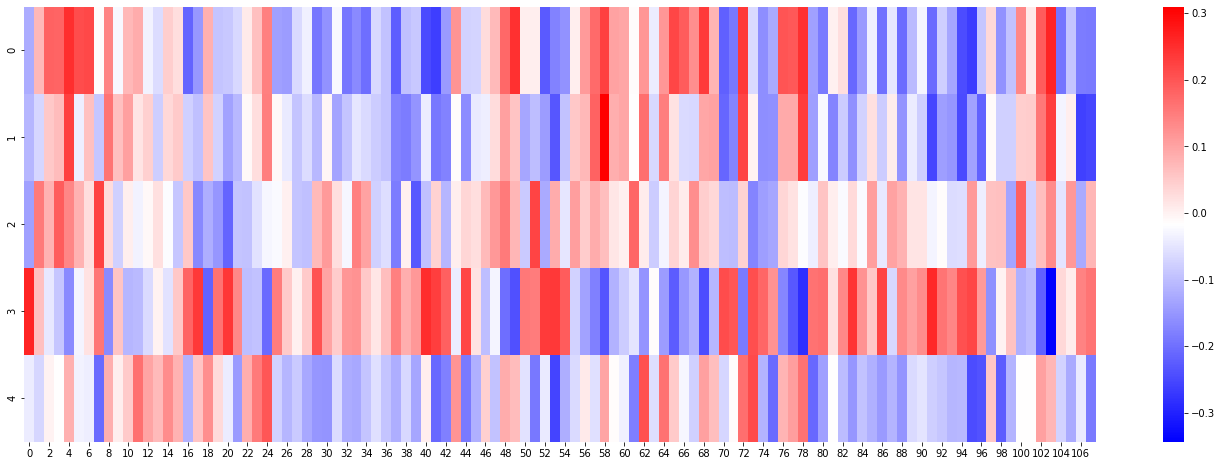

In [40]:
M=corr1[2]
import seaborn as sns
plt.figure(figsize=(24,8))
sns.heatmap(M,cmap='bwr')


In [41]:
totcorr1=corr1[0]
for k in range(len(corr1)-1):
    totcorr1=np.concatenate((totcorr1,corr1[k+1]))

In [15]:
corr2=[]
wSC,vSC=np.linalg.eig(A108_SCS)
for subject in Boldwt.keys():
    B1=Boldwt[subject]
    ca=(CAP(B1,thresh=98))
    M=np.zeros((ca.shape[0],10))
    
    for k in range(ca.shape[0]):
        var=ca[k,:]
        fc=edge_to_FC(var)
        w,v=np.linalg.eig(fc)
        for p in range(10):
            M[k,p]=stats.pearsonr(v[:,0],vSC[:,p])[0]
    corr2.append(M)

/home/etienne/env/lib/python3.8/site-packages/scipy/stats/stats.py:3960: ComplexWarning: Casting complex values to real discards the imaginary part
  prob = 2*special.btdtr(ab, ab, 0.5*(1 - abs(np.float64(r))))
<ipython-input-15-dec3b3e22ef5>:13: ComplexWarning: Casting complex values to real discards the imaginary part
  M[k,p]=stats.pearsonr(v[:,0],vSC[:,p])[0]


In [16]:
totcorr2=corr2[0]
for k in range(len(corr2)-1):
    totcorr2=np.concatenate((totcorr2,corr2[k+1]))

<AxesSubplot:>

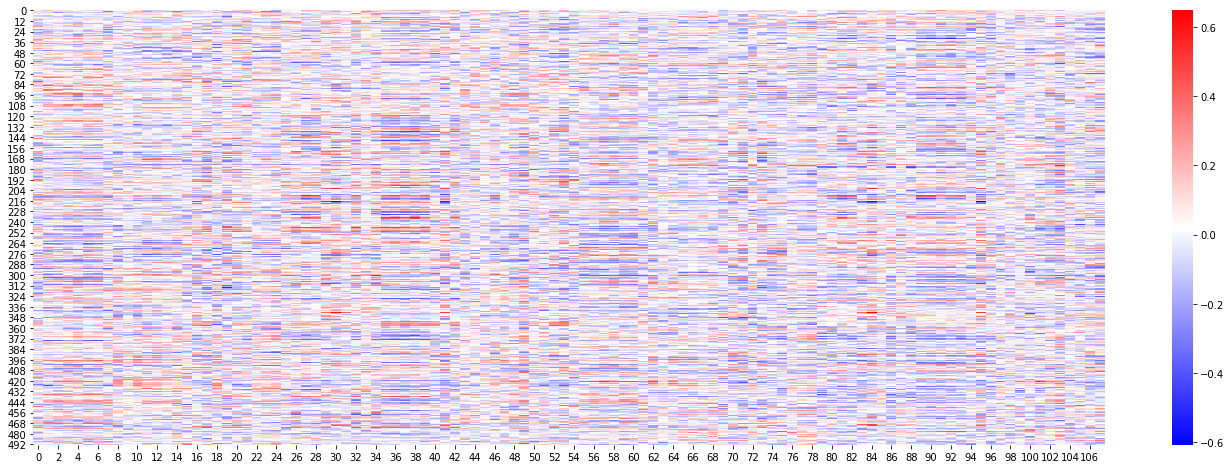

In [42]:
plt.figure(figsize=(24,8))
sns.heatmap(totcorr1,cmap='bwr')

<AxesSubplot:>

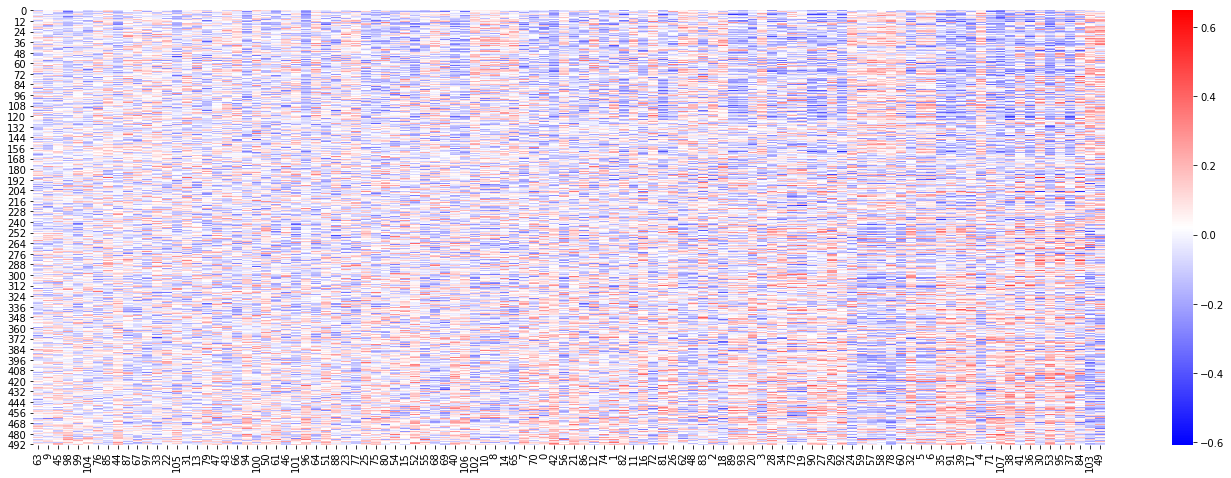

In [43]:
plt.figure(figsize=(24,8))
order=np.argsort(np.sum(np.abs(totcorr1),axis=0))
totcorr1_ord=totcorr1[:,order]
sns.heatmap(totcorr1_ord[np.argsort(np.sum(totcorr1_ord,axis=1)),:],cmap='bwr',xticklabels=order)

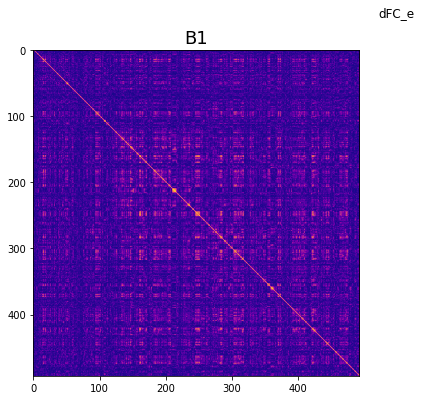

In [44]:
plt.figure(figsize=(14,6))
plt.suptitle('dFC_e')
plt.subplot(121)
plt.title('B1',fontsize=18)
plt.imshow(np.corrcoef(analysis.go_edge(totcorr1)),cmap='plasma')

<Figure size 1728x576 with 0 Axes>

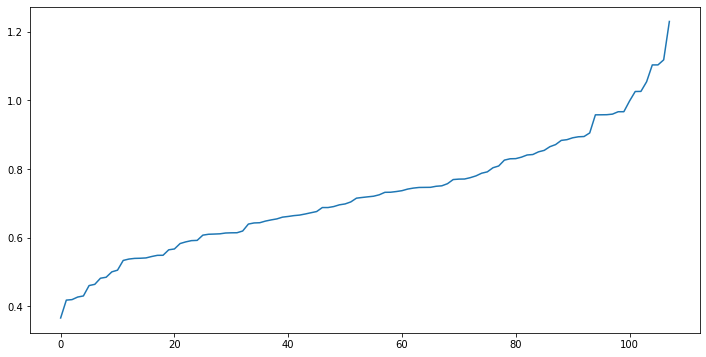

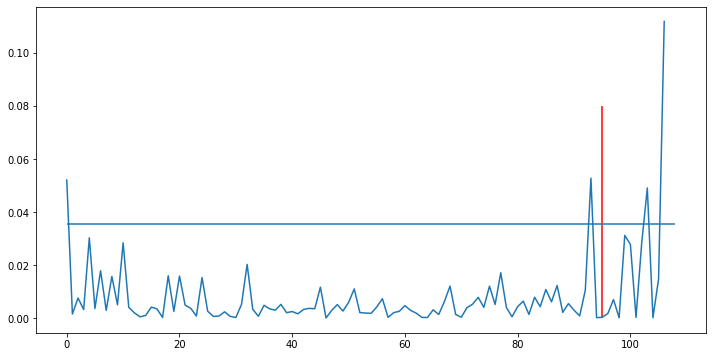

In [45]:
cap=corr1[1]
plt.figure(figsize=(24,8))
order=np.argsort(np.sum(np.abs(cap),axis=0))
cap_ord=cap[:,order]

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.sum(np.abs(cap_ord),axis=0))

gradient=np.sum(np.abs(cap_ord),axis=0)[1:]-np.sum(np.abs(cap_ord),axis=0)[:107]
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(gradient)
ax.vlines(95,0,0.08,colors='r')
ax.hlines(10*np.median(gradient),0,108)

In [46]:
def detect_elbow(cap):
    order=np.argsort(np.sum(np.abs(cap),axis=0))
    cap_ord=cap[:,order]
    gradient=np.sum(np.abs(cap_ord),axis=0)[1:]-np.sum(np.abs(cap_ord),axis=0)[:107]
    
    
    thresh=12*np.median(gradient)
    if (np.arange(107)[gradient>thresh]>95).any():
        elbow=np.min(np.arange(107)[gradient>thresh][np.arange(107)[gradient>thresh]>95])
    
        return(True,regions108.iloc[order[elbow:]].index)

    return(False,np.nan)

In [47]:
CAP_elbow=np.zeros(108)
for k in range(len(corr1)):
    if detect_elbow(corr1[k])[0]:
        elbow_regions=detect_elbow(corr1[k])[1]
        CAP_elbow[elbow_regions]+=1
        
regions108['CAP_elbow']=CAP_elbow

<ipython-input-47-a85e5c2770fa>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regions108['CAP_elbow']=CAP_elbow


In [48]:
regions108

,regions,module,remove_ROI,CAP_elbow
0,"Right Frontal pole, cerebral cortex",Other,False,5.0
1,Right Primary motor area,LCN,False,0.0
2,"Right Primary somatosensory area, nose",LCN,False,0.0
3,"Right Primary somatosensory area, barrel field",LCN,False,2.0
4,"Right Primary somatosensory area, lower limb",LCN,False,1.0
...,...,...,...,...
103,Left Lateral dorsal nucleus of thalamus,Th,False,7.0
104,Left Mediodorsal nucleus of thalamus,Hc,False,1.0
105,Left Reticular nucleus of the thalamus,Th,False,0.0
106,Left Anterior hypothalamic nucleus,VM,False,1.0


In [49]:
regions108.iloc[np.argmax(regions108['CAP_elbow'])]

regions       Right Lateral hypothalamic area
module                                     VM
remove_ROI                              False
CAP_elbow                                10.0
Name: 53, dtype: object

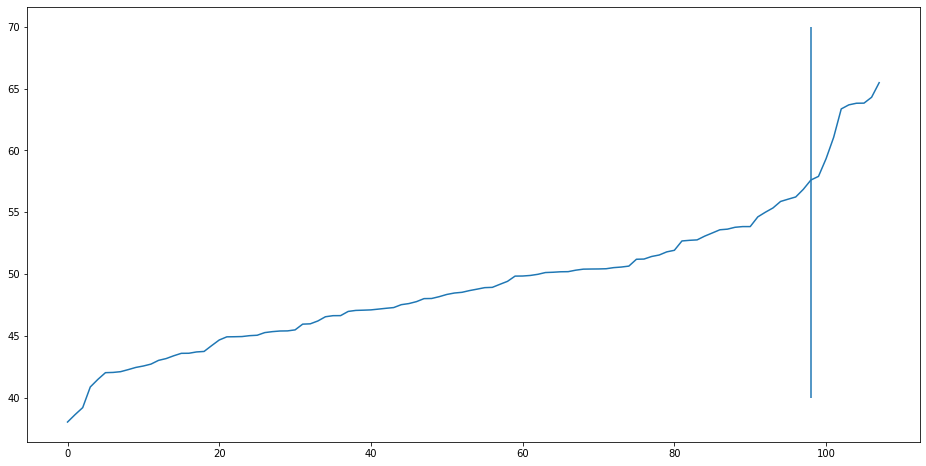

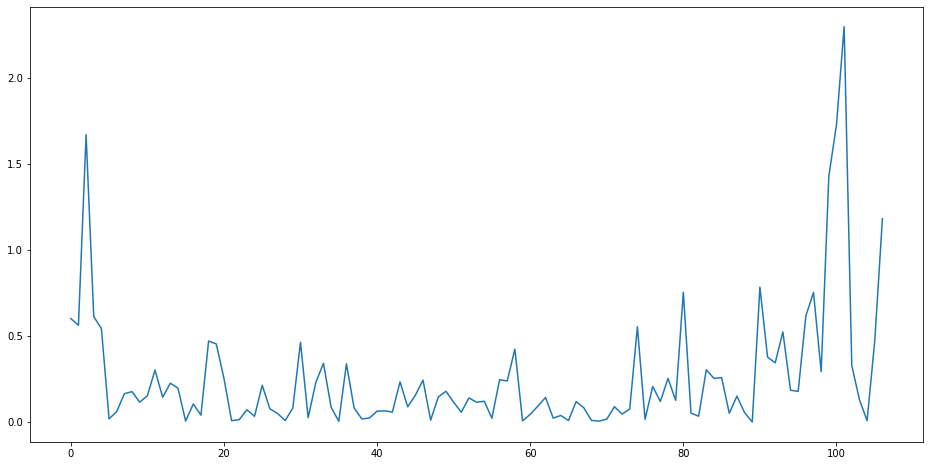

In [37]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(np.sum(np.abs(totcorr1_ord),axis=0))
ax.vlines(98,40,70)

gradient=np.sum(np.abs(totcorr1_ord),axis=0)[1:]-np.sum(np.abs(totcorr1_ord),axis=0)[:107]
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(gradient)

In [38]:
regions108.iloc[order[98:]]

,regions,module,remove_ROI,CAP_elbow
83,Left Field CA1,Hc,False,8.0
60,"Left Primary somatosensory area, upper limb",LCN,False,3.0
78,"Left Retrosplenial area, ventral part",DMN,False,8.0
24,"Right Retrosplenial area, ventral part",DMN,False,5.0
95,"Left Lateral septal nucleus, rostral (rostrove...",BF,False,9.0
30,Right Field CA3,Hc,False,9.0
41,"Right Lateral septal nucleus, rostral (rostrov...",BF,False,11.0
103,Left Lateral dorsal nucleus of thalamus,Th,False,9.0
84,Left Field CA3,Hc,False,14.0
49,Right Lateral dorsal nucleus of thalamus,Th,False,16.0
